In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf, erfc, ive, iv
from scipy.signal import find_peaks

from matplotlib import rc
from matplotlib import animation
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [2]:
def SNR_regularized_delta_source(r,S0,n,lbda,KD,Rcell,epsilon=1):

    r[r==0] =  -1
    
    r_ep = r/(2*epsilon)**0.5
    s_ep = (epsilon/2/lbda**2)**0.5
    
    Erf1  = erf(r_ep-s_ep)
    Erfc2 = erfc(r_ep+s_ep)
    
    fr = 0.5*np.exp(s_ep**2) * (1+Erf1 - np.exp(2*r/lbda)*Erfc2)
    
    Cr = S0 * np.exp(-r/lbda)/r * fr
    
    fp_over_f= ( (8/np.pi/epsilon)**0.5 * np.exp(-(r_ep-s_ep)**2)
                 - 2/lbda * Erfc2*np.exp(2*r/lbda) ) \
                / ( 1 + Erf1 - Erfc2*np.exp(2*r/lbda) )
    
    p = 2*Rcell*np.abs(1/r+1/lbda-fp_over_f)
    
    Cr[r<0] = S0 * ((2/np.pi/epsilon)**0.5-np.exp(s_ep**2)*(1-erf(s_ep))/lbda)
    p[r<0] = 0
    sigma2_p = 8*(Cr + KD)**2/(n*Cr*KD)
    
    return p**2/sigma2_p, Cr

def equipotency_vec(x,x0A,x0B,SA,SB,nA,nB,lbdaA,lbdaB,KDA,KDB,Rcell,epsilon=16):

    rA = ((x-x0A)**2)**0.5
    rB = ((x-x0B)**2)**0.5
    
    SNRA, CrA = SNR_regularized_delta_source(rA,SA,nA,lbdaA,KDA,Rcell,epsilon)
    SNRB, CrB = SNR_regularized_delta_source(rB,SB,nB,lbdaB,KDB,Rcell,epsilon)

    # print(SNRA,SNRB)
    f = 0*SNRA
    x1 = np.where(x<x0A)
    x2 = np.where((x>=x0A) & (x<x0B))
    x3 = np.where(x>=x0B)
    f[x1] = SNRA[x1] + SNRB[x1]
    f[x2] = -SNRA[x2] + SNRB[x2]
    f[x3] = -SNRA[x3] - SNRB[x3]

    return f

[49.60744531] [49.60744531] [12707.44319154]


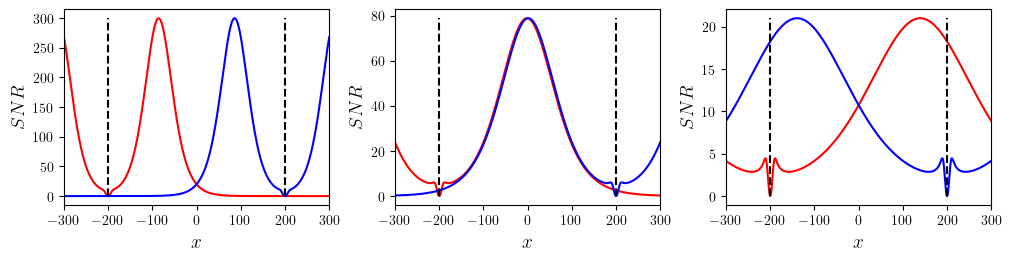

In [3]:
from scipy.optimize import fsolve 

Rcell = 10

n = 10000 # number of type A receptors
KD = 1 # dissociation constant A
lbda = 25.0 # chemokine lengthscale A 0.05-0.1 nM/s
S0 = 6404.0 # source A size in units of gamma

epsilon=16

fig, ax = plt.subplots(1,3,figsize=(10,2.5),layout='constrained')

x0A,y0A = -200,0 #position source A
x0B,y0B = 200,0 #position source B

K_ = KD/S0*lbda
Delta_x = x0B-x0A

### finding \lambda^*
func = lambda x : 2*x*(Delta_x**2 + 8*x*Delta_x -4*x**2 ) - K_*np.exp(Delta_x/2/x) * (Delta_x**3 + 8*x*Delta_x**2 + 12*x**2*Delta_x )

x0 = 5
xf = fsolve(func, x0)

lbda = xf
S0 = KD*lbda/K_

print(xf, lbda,S0)

lambda_vec = [lbda*x for x in [0.5,1.0,2]]

xt = np.linspace(-300,300,500)
for i, lmbda in enumerate(lambda_vec):
    nA, KDA, lambdaA, SA = n, KD, lmbda, S0
    nB, KDB, lambdaB, SB = n, KD, lmbda, S0
  
    rA = ((xt-x0A)**2)**0.5
    rB = ((xt-x0B)**2)**0.5
    
    SNRA,CrA = SNR_regularized_delta_source(rA,SA,nA,lambdaA,KDA,Rcell, epsilon=epsilon)
    SNRB,CrB = SNR_regularized_delta_source(rB,SB,nB,lambdaB,KDB,Rcell, epsilon=epsilon)

    ax[i].plot(xt,SNRA, '-r')
    ax[i].plot(xt,SNRB, '-b')
    ax[i].plot([x0A,x0A],[np.min(SNRA), np.max(SNRA)],'--k')
    ax[i].plot([x0B,x0B],[np.min(SNRB), np.max(SNRB)],'--k')
    ax[i].set_xlim([-300,300])
    ax[i].set_xlabel('$x$', fontsize=14)
    ax[i].set_ylabel('$SNR$', fontsize=14)

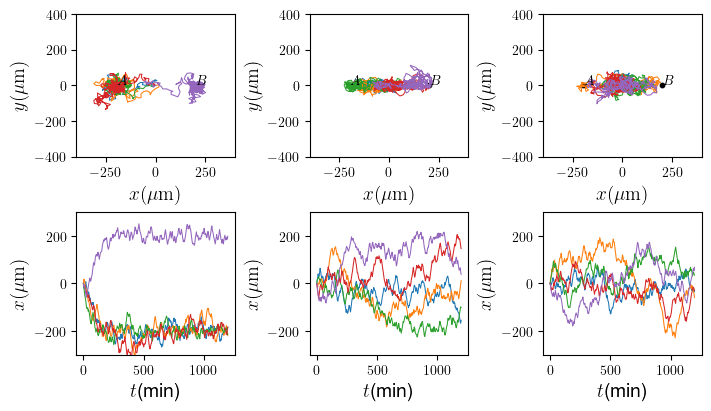

In [4]:
#### Rcell = 10

dt_r = 0.01
T = 10000.0
Ntraj = 100

#cell
v0 = 5.0 # cell speed
Rcell = 10.0 # cell radius
Dtheta = 0.4 # polarity noise
tau = 2.0 # relaxation rate
L0 = v0*tau

epsilon=16

dt= tau*dt_r
nt = int(T/dt)

# Chemokine A
n = 10000 # number of type A receptors
KD = 1.0 # dissociation constant A
S0 = 12810.0
lbda = 50.0

x0A,y0A = -200,0 #position source A
x0B,y0B = 200,0 #position source B
x0s,y0s = 0,0 #position source A

nA, KDA, lambdaA, SA = n, KD, lbda, S0
nB, KDB, lambdaB, SB = n, KD, lbda, S0


dir = "./data/2Gradients/"

fig, ax = plt.subplots(2,3, figsize=(7,4), layout='constrained')

lambda_vec = [25.0,50.0,100.0]

Ntraj_plot = np.random.choice(Ntraj, 5, replace=False)
for j, lbda in enumerate(lambda_vec):
    filename = 'N_{0}_v0_{1}_tau_{2}_Dth_{3}_n_{4}_KD_{5}_lambda_{6}_S0_{7}_T_{8}_dt_{9}'.format(Ntraj,v0,tau,Dtheta,n,KD,lbda,S0,T,dt_r)
    data = np.loadtxt(dir+"prw2grads_pos_vs_t_"+filename+".dat")

    l = len(data[:,0])//Ntraj
    dt = T/l
    t = np.arange(0,T,dt)
    tmax=300
    for i  in Ntraj_plot:
        x = data[i*l:(i+1)*l-1,0]
        y = data[i*l:(i+1)*l-1,1]   
        ax[0,j].plot(x[:tmax],y[:tmax],lw=0.75)
        ax[1,j].plot(t[:tmax],x[:tmax],lw=0.75)
        
    ax[0,j].set_xlim([-400,400])
    ax[0,j].set_ylim([-400,400])
    ax[0,j].set_xlabel('$x(\mu\mathrm{m})$', fontsize=14)
    ax[0,j].set_ylabel('$y(\mu\mathrm{m})$', fontsize=14)

    ax[0,j].scatter(x0A, y0A, marker='o',s=10,c='k')
    ax[0,j].scatter(x0B, y0B, marker='o',s=10,c='k')
    ax[0,j].text(x0A+5, y0A+5, '$A$')
    ax[0,j].text(x0B+5, y0B+5, '$B$')

    ax[1,j].set_xlabel('$t$(min)', fontsize=14)
    ax[1,j].set_ylabel('$x(\mu\mathrm{m})$', fontsize=14)
    ax[1,j].set_ylim([-300,300])

[299] [-0.50083472] [15677.77890647]
[ 99 499] [-200.83472454  199.83305509] [-8155.02315577 -8155.02315577]
[154 444] [-145.74290484  144.74123539] [-1086.08722047 -1086.08722047]
[105 299 493] [-194.82470785   -0.50083472  193.8230384 ] [-1131.91725995 -1129.88652338 -1131.91725995]
[] [] []
[299] [-0.50083472] [-4198.73967042]


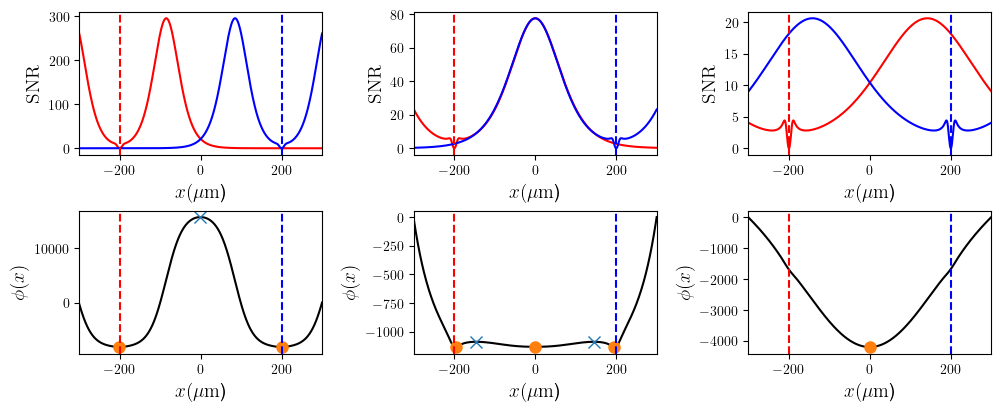

In [5]:

Rcell = 10

# Chemokine A
n = 10000 # number of type A receptors
KD = 1.0 # dissociation constant A
lbda = 100.0 # chemokine lengthscale A 0.05-0.1 nM/s
S0 = 12810.0 # source A size in units of gamma

epsilon=16

x0A,y0A = -200,0 #position source A
x0B,y0B = 200,0 #position source B

nA, KDA, lbdaA, SA = n, KD, lbda, S0
nB, KDB, lbdaB, SB = n, KD, lbda, S0

fig, ax = plt.subplots(2,3, figsize=(10,4),layout='constrained' ) 

x = np.linspace(-300,300,600)
dx = x[1]-x[0]
rA = ((x-x0A)**2)**0.5
rB = ((x-x0B)**2)**0.5

lbda_vec = [25.0, 50, 100.0]
for i, lbda_i in enumerate(lbda_vec):

    lbdaA = lbda_i
    lbdaB = lbda_i

    SNRA, CrA = SNR_regularized_delta_source(rA,SA,nA,lbdaA,KDA,Rcell,epsilon=16)
    SNRB, CrB = SNR_regularized_delta_source(rB,SB,nB,lbdaB,KDB,Rcell,epsilon=16)

    ax[0,i].plot(x,SNRA, '-r')
    ax[0,i].plot(x,SNRB, '-b')
    
    f = equipotency_vec(x,x0A,x0B,SA,SB,nA,nB,lbdaA,lbdaB,KDA,KDB,Rcell,epsilon=16)

    phi = -np.cumsum(f)*dx

    xfpu, _ = find_peaks(phi**3, threshold=0.2)
    xfps, _ = find_peaks(-phi**3, threshold=0.2)
    print(xfpu,x[xfpu],phi[xfpu])
    print(xfps,x[xfps],phi[xfps])

    ax[1,i].plot(x,phi, '-k')
    ax[1,i].plot(x[xfpu], phi[xfpu], "x", ms=8)
    ax[1,i].plot(x[xfps], phi[xfps], "o", ms=8)
    
    ax[0,i].axvline(x0A, ymin=0, ymax=1,ls='--',c='r')
    ax[0,i].axvline(x0B, ymin=0, ymax=1,ls='--',c='b')
    ax[0,i].set_xlim([-300,300])
    ax[0,i].set_xlabel('$x (\mu\mathrm{m}$)', fontsize=14)
    ax[0,i].set_ylabel('$\mathrm{SNR}$', fontsize=14)
    
    
    ax[1,i].axvline(x0A, ymin=0, ymax=1,ls='--',c='r')
    ax[1,i].axvline(x0B, ymin=0, ymax=1,ls='--',c='b')
    ax[1,i].set_xlim([-300,300])
    ax[1,i].set_xlabel('$x (\mu\mathrm{m}$)', fontsize=14)
    ax[1,i].set_ylabel('$\phi(x)$', fontsize=14)

Text(0, 0.5, '$x (\\mu\\mathrm{m})$')

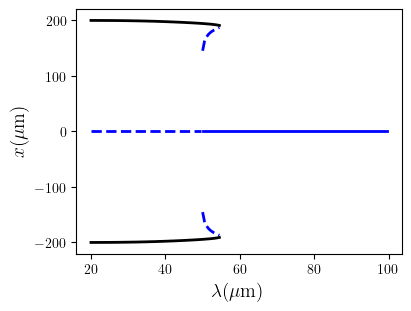

In [6]:
Rcell = 10

#cell
v0 = 5.0 # cell speed
Rcell = 10.0 # cell radius
Dtheta = 0.4 #0.01 # polarity noise
tau = 2.0 # relaxation rate
L0 = v0*tau

dt= tau*dt_r
nt = int(T/dt)
t = np.linspace(0,T,nt)

# Chemokine A
n = 10000 # number of type A receptors
KD = 1.0 # dissociation constant A
lbda = 50.0 # chemokine lengthscale A 0.05-0.1 nM/s
S0 = 12810.0 # source A size in units of gamma

epsilon=16

x0A,y0A = -200,0 #position source A
x0B,y0B = 200,0 #position source B

nA, KDA, lbdaA, SA = n, KD, lbda, S0
nB, KDB, lbdaB, SB = n, KD, lbda, S0

fig, ax = plt.subplots(figsize=(4,3),layout='constrained' ) 

x = np.linspace(-250,250,10000)
dx = x[1]-x[0]

lbda_vec = np.arange(20.0,100,0.5)

xpfu_v =[]
xpfs_v =[]

for i, lbda_i in enumerate(lbda_vec):

    lbdaA = lbda_i
    lbdaB = lbda_i

    f = equipotency_vec(x,x0A,x0B,SA,SB,nA,nB,lbdaA,lbdaB,KDA,KDB,Rcell,epsilon=16)

    phi = -np.cumsum(f)*dx

    xfpu, _ = find_peaks(phi**3, threshold=0.2)
    xfps, _ = find_peaks(-phi**3, threshold=0.2)

    for xfpu_i in xfpu:
        xpfu_v.append([lbda_i,xfpu_i])

    for xfps_i in xfps:
        xpfs_v.append([lbda_i,xfps_i])

xpfu_v = np.array(xpfu_v)
xpfs_v = np.array(xpfs_v)


eps = 0.5
x_equi = 0

xu = xpfu_v[:,0]
yu = x[xpfu_v[:,1].astype(int)]

ax.plot(xu[yu-x_equi>eps],yu[yu-x_equi>eps], "--b",lw=2)
ax.plot(xu[yu-x_equi<-eps],yu[yu-x_equi<-eps], "--b",lw=2)
ax.plot(xu[(yu-x_equi)**2<eps**2],yu[(yu-x_equi)**2<eps**2], "--b",lw=2)

xs = xpfs_v[:,0]
ys = x[xpfs_v[:,1].astype(int)]

ax.plot(xs[ys-x_equi>eps],ys[ys-x_equi>eps], "-k",lw=2)
ax.plot(xs[ys-x_equi<-eps],ys[ys-x_equi<-eps], "-k",lw=2)
ax.plot(xs[(ys-x_equi)**2<eps**2],ys[(ys-x_equi)**2<eps**2], "-b",lw=2)
ax.set_xlabel('$\lambda (\mu\mathrm{m})$', fontsize=14)
ax.set_ylabel('$x (\mu\mathrm{m})$', fontsize=14)